In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import pickle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_excel(r'C:\Users\cmcampos.REDESESCRIO\Desktop\Filmes Tera\projeto_filme_tera\bases_de_dados\dados_para_split123.xlsx')

### MACHINE LEARNING

In [3]:
df['Budget ($million)'] = df['Budget ($million)'].astype(float)

In [4]:
tipos_de_coluna = df.dtypes
print(tipos_de_coluna)

Budget ($million)            float64
Oscar Winners                  int64
Runtime (Minutes)            float64
Action                       float64
Adventure                    float64
                              ...   
Director_Woody Allen           int64
Director_Yimou Zhang           int64
Director_Yorgos Lanthimos      int64
Director_Zack Snyder           int64
Director_nan                   int64
Length: 383, dtype: object


In [5]:
df = df.dropna(subset=['sucesso_recalculado'])

In [6]:
df

,Budget ($million),Oscar Winners,Runtime (Minutes),Action,Adventure,Animation,Biography,Comedy,Crime,Drama,...,Director_Wes Ball,Director_Wes Craven,Director_Whit Stillman,Director_Will Gluck,Director_William Brent Bell,Director_Woody Allen,Director_Yimou Zhang,Director_Yorgos Lanthimos,Director_Zack Snyder,Director_nan
0,0.00,0,118.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0.45,0,103.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.50,0,103.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,6.50,0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,9.00,0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,60.00,0,90.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
498,65.00,0,129.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
499,50.00,0,161.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
500,7.00,0,119.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


Load features and target data

In [7]:
X = df.drop("sucesso_recalculado", axis=1)
y = df["sucesso_recalculado"]

In [8]:
y

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
497    0.0
498    0.0
499    0.0
500    0.0
501    0.0
Name: sucesso_recalculado, Length: 500, dtype: float64

Separa os dados em treino e teste

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(375, 382) (375,)
(125, 382) (125,)


In [10]:
columns_to_scale = ["Budget ($million)", "Runtime (Minutes)"]

In [11]:
#Let's created an empty standard scalar object
scaler = StandardScaler()

In [12]:
#fit our input data, this will calculate the mean and standard deviation of each feature from unskilled inputs
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [13]:
# Especifique o nome do arquivo onde você deseja salvar o scaler
nome_arquivo = "standard_scaler_com_diretor.pkl"

# Use a função joblib.dump para salvar o scaler
joblib.dump(scaler, nome_arquivo)

['standard_scaler_com_diretor.pkl']

Cria função pra avaliar os modelos

In [14]:
def evaluate(model, X_train, X_test, y_train, y_test):
    '''
    Avalia o desempenho de um modelo de machine learning nos dados de treino e teste.

    Parâmetros:
    -----------
    model : objeto de modelo de machine learning
        O modelo de machine learning treinado a ser avaliado.

    X_train : array-like de forma (n_amostras, n_características)
        Os dados de entrada do treino.

    X_test : array-like de forma (n_amostras, n_características)
        Os dados de entrada do teste.

    y_train : array-like de forma (n_amostras,)
        Os dados de destino do treino.

    y_test : array-like de forma (n_amostras,)
        Os dados de destino do teste.

    Retorna:
    --------
    None
    '''
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("RESULTADOS DO TREINO: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"MATRIZ DE CONFUSÃO:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"PONTUAÇÃO DE ACURÁCIA:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"RELATÓRIO DE CLASSIFICAÇÃO:\n{clf_report}")

    print("RESULTADOS DO TESTE: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"MATRIZ DE CONFUSÃO:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"PONTUAÇÃO DE ACURÁCIA:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"RELATÓRIO DE CLASSIFICAÇÃO:\n{clf_report}")


inserir métricas de recall e precisão e f1.
temos que evitar falsos positivos - qual a melhor métrica? PRECISÃO!

Cria funções pra plotar gráficos de recall e precisão e ROC

In [15]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Plota a precision e recall em relação ao threshold de classificação.

    Args:
        precisions (array-like): Um array que contém os valores de precision.
        recalls (array-like): Um array que contém os valores de recall.
        thresholds (array-like): Um array que contém os valores de threshold.

    Returns:
        None
    """
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.title("Precision/Recall Tradeoff")

def plot_roc_curve(fpr, tpr, label=None):
    """
    Plota a curva ROC.

    Args:
        fpr (array-like): Um array que contém os valores da taxa de falsos positivos.
        tpr (array-like): Um array que contém os valores da taxa de verdadeiros positivos.
        label (string, optional): Label para a curva ROC. Default é None.

    Returns:
        None
    """
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

###  1. Regressão logística

In [16]:
print("\n=========LOGISTIC REGRESSION============")

n_estimators = [100, 500, 1000, 1500]
max_features = ['auto', 'sqrt']
max_depth = [2, 5, 10, 15, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Cria um objeto de regressão logística
lr_clf = LogisticRegression(random_state=20, solver='liblinear', penalty='l1')

# Cria um objeto GridSearchCV para otimizar os hiperparâmetros
grid_search = GridSearchCV(lr_clf, param_grid, scoring="accuracy", cv=5)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Melhores parâmetros: {best_params}")

# Cria um novo objeto de Regressão Logística com os melhores parâmetros encontrados
lr_clf = LogisticRegression(**best_params)
lr_clf.fit(X_train, y_train)

# Avalia o desempenho do modelo
evaluate(lr_clf, X_train, X_test, y_train, y_test)


=========LOGISTIC REGRESSION============


c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Melhores parâmetros: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
RESULTADOS DO TREINO: 
MATRIZ DE CONFUSÃO:
[[273   7]
 [ 28  67]]
PONTUAÇÃO DE ACURÁCIA:
0.9067
RELATÓRIO DE CLASSIFICAÇÃO:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.906977   0.905405  0.906667    0.906191      0.906579
recall       0.975000   0.705263  0.906667    0.840132      0.906667
f1-score     0.939759   0.792899  0.906667    0.866329      0.902555
support    280.000000  95.000000  0.906667  375.000000    375.000000
RESULTADOS DO TESTE: 
MATRIZ DE CONFUSÃO:
[[93  4]
 [23  5]]
PONTUAÇÃO DE ACURÁCIA:
0.7840
RELATÓRIO DE CLASSIFICAÇÃO:
                 0.0        1.0  accuracy   macro avg  weighted avg
precision   0.801724   0.555556     0.784    0.678640      0.746582
recall      0.958763   0.178571     0.784    0.568667      0.784000
f1-score    0.873239   0.270270     0.784    0.571755      0.738174
support    97.000000  28.000000     0.784  125.0000

c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cria gráficos para avaliar precisão e recall

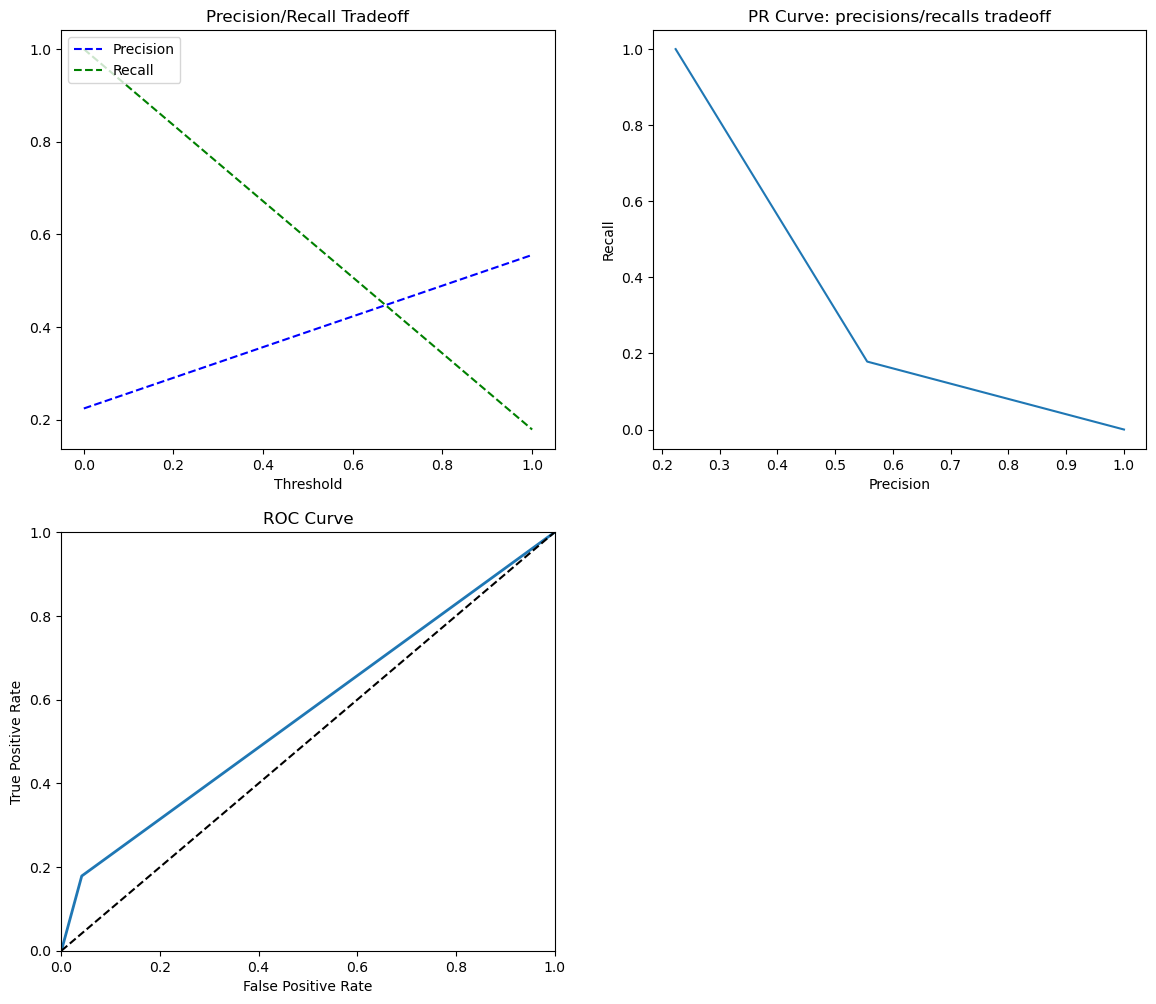

In [17]:
precisions, recalls, thresholds = precision_recall_curve(y_test, lr_clf.predict(X_test))
plt.figure(figsize=(14, 25))
plt.subplot(4, 2, 1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.subplot(4, 2, 2)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff");

plt.subplot(4, 2, 3)
fpr, tpr, thresholds = roc_curve(y_test, lr_clf.predict(X_test))
plot_roc_curve(fpr, tpr)

In [18]:
scores_dict = {
    'Logistic Regression': {
        'Train': accuracy_score(y_train, lr_clf.predict(X_train)),
        'Test': accuracy_score(y_test, lr_clf.predict(X_test)),
    },
}

In [19]:
scores = cross_val_score(lr_clf, X_train, y_train, cv=10)

print(f"Scores: {scores}")
print(f"Cross-Validation score mean: {scores.mean() * 100:.2f}% (+/-{scores.std() * 100:.2f})")

Scores: [0.76315789 0.89473684 0.78947368 0.76315789 0.78947368 0.75675676
 0.78378378 0.78378378 0.81081081 0.72972973]
Cross-Validation score mean: 78.65% (+/-4.19)


### Random Forest

In [20]:
print("\n=========RANDOM FOREST============")
#5 trees took 16s precision   0.805310
#10 trees took 27s precision   0.810811
#50 trees took 1m27s precision   0.805556
#100 trees took 2m23s precision   0.816514
#500 trees took 11m21s precision   0.809091
#n_estimators = [100, 500, 1000, 1500]
n_estimators = [5, 10, 50, 100, 500]
max_features = ['auto', 'sqrt']
max_depth = [2, 5, 10, 15, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

params_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf_clf = RandomForestClassifier(random_state=20)

rf_cv = GridSearchCV(rf_clf, params_grid, scoring="f1", cv=5, verbose=1, n_jobs=-1)


rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

evaluate(rf_clf, X_train, X_test, y_train, y_test)


=========RANDOM FOREST============
Fitting 5 folds for each of 900 candidates, totalling 4500 fits


c:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RESULTADOS DO TREINO: 


c:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


MATRIZ DE CONFUSÃO:
[[280   0]
 [  0  95]]
PONTUAÇÃO DE ACURÁCIA:
1.0000
RELATÓRIO DE CLASSIFICAÇÃO:
             0.0   1.0  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    280.0  95.0       1.0      375.0         375.0
RESULTADOS DO TESTE: 
MATRIZ DE CONFUSÃO:
[[92  5]
 [21  7]]
PONTUAÇÃO DE ACURÁCIA:
0.7920
RELATÓRIO DE CLASSIFICAÇÃO:
                 0.0        1.0  accuracy   macro avg  weighted avg
precision   0.814159   0.583333     0.792    0.698746      0.762454
recall      0.948454   0.250000     0.792    0.599227      0.792000
f1-score    0.876190   0.350000     0.792    0.613095      0.758324
support    97.000000  28.000000     0.792  125.000000    125.000000


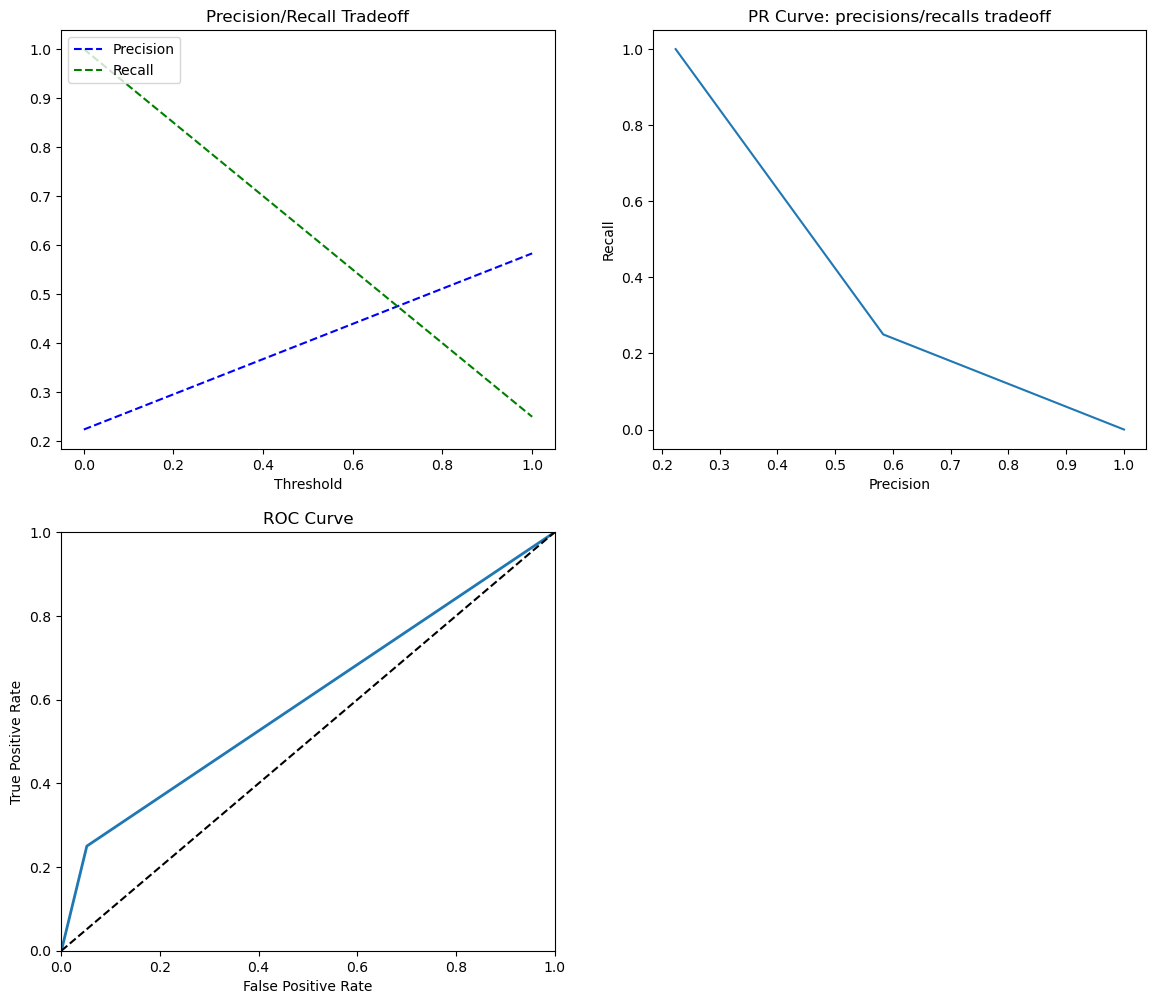

In [21]:
precisions, recalls, thresholds = precision_recall_curve(y_test, rf_clf.predict(X_test))
plt.figure(figsize=(14, 25))
plt.subplot(4, 2, 1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.subplot(4, 2, 2)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff");

plt.subplot(4, 2, 3)
fpr, tpr, thresholds = roc_curve(y_test, rf_clf.predict(X_test))
plot_roc_curve(fpr, tpr)

In [22]:
scores_dict['Random Forest'] = {
        'Train': accuracy_score(y_train, rf_clf.predict(X_train)),
        'Test': accuracy_score(y_test, rf_clf.predict(X_test)),
    }

### GradientBoostingClassifier

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

n_estimators = [50, 100, 250]
max_depth = [2, 3, 5, 10, 15]
learning_rate = [0.05, 0.1, 0.5, 0.9, 1]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

params_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

xgb_clf = GradientBoostingClassifier(random_state=20)

xgb_cv = GridSearchCV(xgb_clf, params_grid, cv=5, scoring = 'f1',n_jobs =-1, verbose=1)


xgb_cv.fit(X_train, y_train)
best_params = xgb_cv.best_params_
print(f"Best paramters: {best_params}")

xgb_clf = xgb.XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

evaluate(xgb_clf, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best paramters: {'learning_rate': 1, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
[11:43:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

RESULTADOS DO TREINO: 
MATRIZ DE CONFUSÃO:
[[273   7]
 [ 24  71]]
PONTUAÇÃO DE ACURÁCIA:
0.9173
RELATÓRIO DE CLASSIFICAÇÃO:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.919192   0.910256  0.917333    0.914724      0.916928
recall       0.975000   0.747368  0.917333    0.861184      0.917333
f1-score     0.946274   0.820809  0.917333    0.883542      0.914489
support    280.000000  95.000000  0.917333  375.000000    375.000000
RESULTADOS DO TESTE: 
MATRIZ DE CONFUSÃO:
[[87 10]
 [21  7]]
PONTUAÇÃO DE ACURÁCIA:
0.7520
RELATÓRIO DE CLASSIFICAÇÃO:
                 0.0        1.0  accuracy   macro avg  we

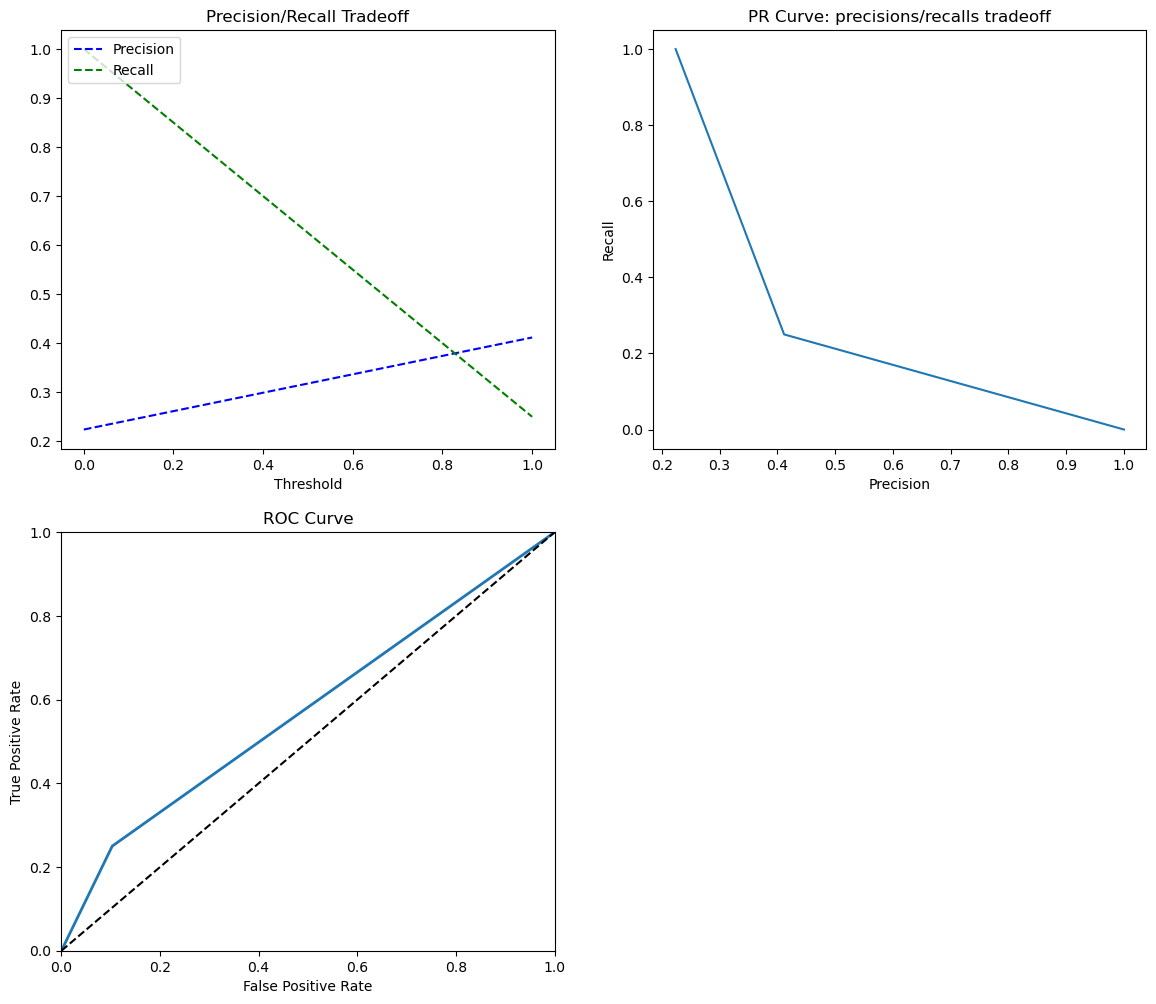

In [24]:
precisions, recalls, thresholds = precision_recall_curve(y_test, xgb_clf.predict(X_test))
plt.figure(figsize=(14, 25))
plt.subplot(4, 2, 1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.subplot(4, 2, 2)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff");

plt.subplot(4, 2, 3)
fpr, tpr, thresholds = roc_curve(y_test, xgb_clf.predict(X_test))
plot_roc_curve(fpr, tpr)

In [25]:
scores_dict['XGBoost'] = {
        'Train': accuracy_score(y_train, xgb_clf.predict(X_train)),
        'Test': accuracy_score(y_test, xgb_clf.predict(X_test)),
    }

### Support Vector Machine

In [26]:
param_grid = {
    'C': [60, 70, 75, 65 ],
    'gamma': [0.002, 0.001, 0.0009, 0.0008, 0.0007],
    'kernel': ['rbf', 'poly', 'linear'],
    'probability': [True, False]
}

svm_cv = GridSearchCV(SVC(random_state=20), param_grid, scoring='f1', verbose=1, cv=5)
svm_cv.fit(X_train, y_train)

best_params = svm_cv.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params)
svm_clf.fit(X_train, y_train)
evaluate(svm_clf, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best params: {'C': 60, 'gamma': 0.0009, 'kernel': 'rbf', 'probability': True}
RESULTADOS DO TREINO: 
MATRIZ DE CONFUSÃO:
[[276   4]
 [  3  92]]
PONTUAÇÃO DE ACURÁCIA:
0.9813
RELATÓRIO DE CLASSIFICAÇÃO:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.989247   0.958333  0.981333    0.973790      0.981416
recall       0.985714   0.968421  0.981333    0.977068      0.981333
f1-score     0.987478   0.963351  0.981333    0.975414      0.981366
support    280.000000  95.000000  0.981333  375.000000    375.000000
RESULTADOS DO TESTE: 
MATRIZ DE CONFUSÃO:
[[81 16]
 [16 12]]
PONTUAÇÃO DE ACURÁCIA:
0.7440
RELATÓRIO DE CLASSIFICAÇÃO:
                 0.0        1.0  accuracy   macro avg  weighted avg
precision   0.835052   0.428571     0.744    0.631811         0.744
recall      0.835052   0.428571     0.744    0.631811         0.744
f1-score    0.835052   0.428571     0.744    0.631811         0.744

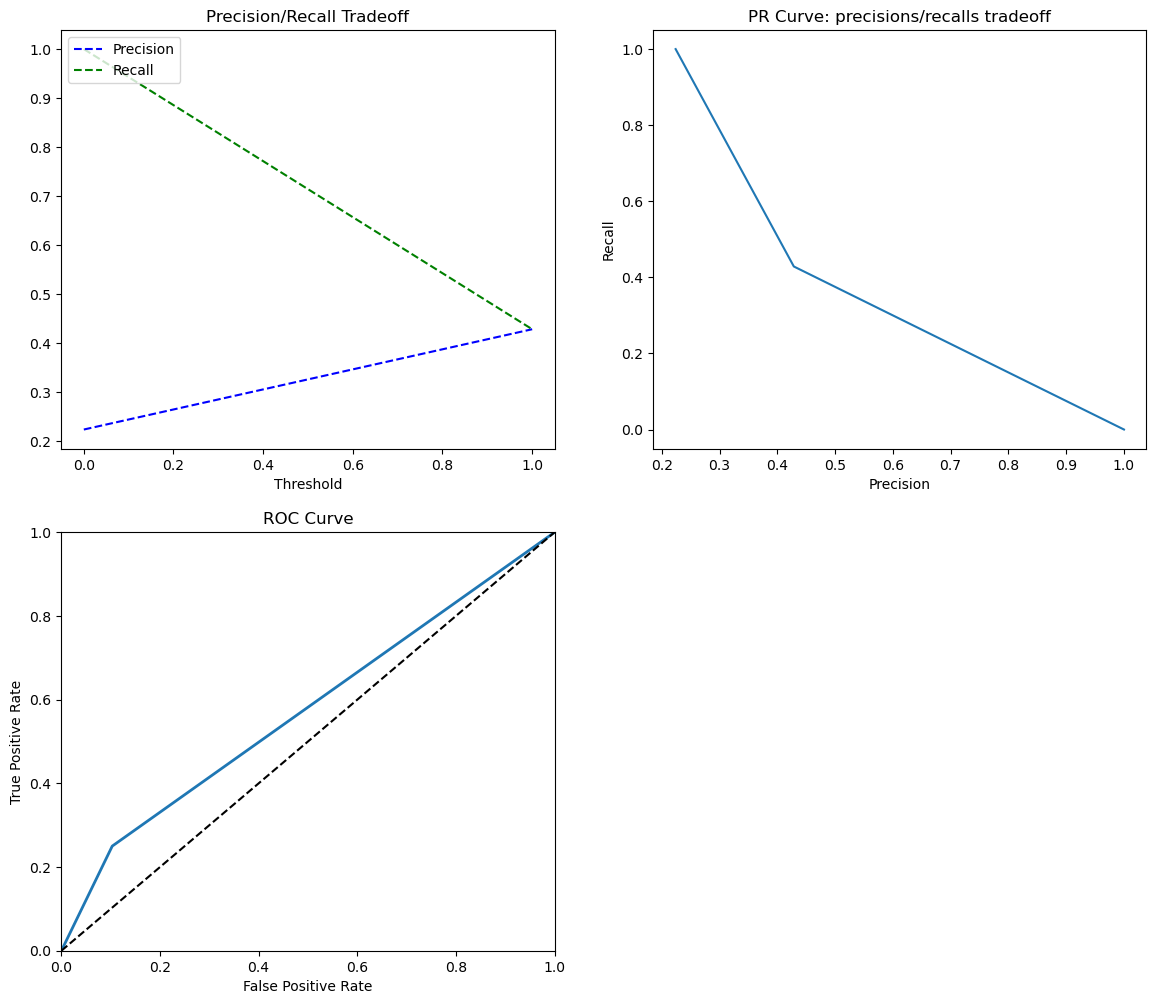

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_test, svm_clf.predict(X_test))
plt.figure(figsize=(14, 25))
plt.subplot(4, 2, 1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.subplot(4, 2, 2)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff");

plt.subplot(4, 2, 3)
fpr, tpr, thresholds = roc_curve(y_test, xgb_clf.predict(X_test))
plot_roc_curve(fpr, tpr)

In [28]:
scores_dict['Support Vector Machine'] = {
        'Train': accuracy_score(y_train, svm_clf.predict(X_train)),
        'Test': accuracy_score(y_test, svm_clf.predict(X_test)),
    }

## Comparação entre os modelos

Load models

In [29]:
#import pickle

#with open('models/lr_clf', 'rb') as file:
#    lr_clf = pickle.load(file)

#with open('models/Rf_clf', 'rb') as file:
#    rf_clf = pickle.load(file)

#with open('models/Xgb_clf', 'rb') as file:
#    xgb_clf = pickle.load(file)

#with open('models/svm_clf', 'rb') as file:
#    svm_clf = pickle.load(file)

In [30]:
ml_models = {
    'Logistic Regression': lr_clf,
    'Random Forest': rf_clf,
    'XGboost': xgb_clf,
    'Support Vector Machine': svm_clf
}
for model in ml_models:
    print(f"{model.upper()} roc_auc_score: {roc_auc_score(y_test, ml_models[model].predict(X_test)):.3f}")

LOGISTIC REGRESSION roc_auc_score: 0.569
RANDOM FOREST roc_auc_score: 0.599
XGBOOST roc_auc_score: 0.573
SUPPORT VECTOR MACHINE roc_auc_score: 0.632


<Axes: >

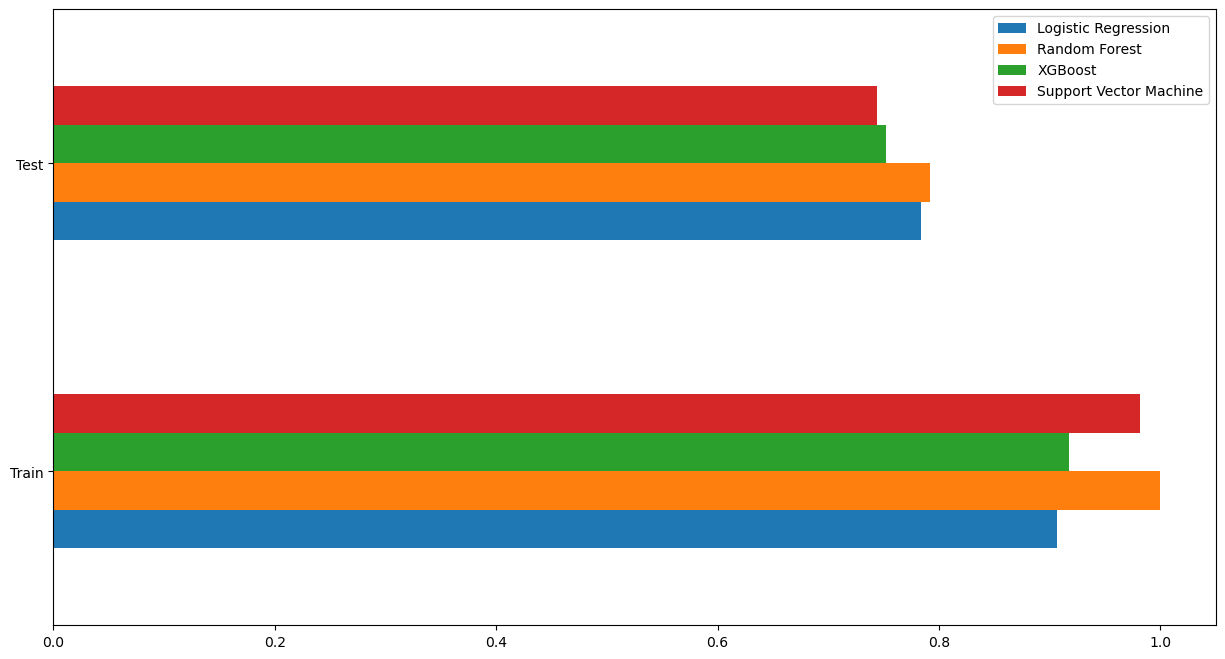

In [31]:
scores_df = pd.DataFrame(scores_dict)

scores_df.plot(kind='barh', figsize=(15, 8))

## Salvar modelos

In [32]:
with open('lr_clf.pkl', 'wb') as file:
    pickle.dump(lr_clf, file)

with open('Rf_clf.pkl', 'wb') as file:
    pickle.dump(rf_clf, file)

with open('Xgb_clf.pkl', 'wb') as file:
    pickle.dump(xgb_clf, file)

with open('svm_clf.pkl', 'wb') as file:
    pickle.dump(svm_clf, file)


## SHAP

Load models

In [33]:
from sklearn.metrics import roc_auc_score

def get_best_model(ml_models, X_test, y_test):
    """
    Retorna o nome do modelo com o maior roc_auc_score a partir de um dicionário de modelos previamente treinados.

    Parâmetros:
    ml_models (dict): Um dicionário de modelos de machine learning previamente treinados, onde as chaves são os nomes dos modelos e os valores são os modelos treinados.
    X_test (array): Um array NumPy de tamanho (n_samples, n_features) contendo os dados de teste.
    y_test (array): Um array NumPy de tamanho (n_samples,) contendo os rótulos correspondentes aos dados de teste.

    Retorna:
    O nome do modelo com o maior roc_auc_score.

    """
    best_score = -1  # valor inicial para comparar os scores
    best_model = None  # valor inicial para guardar o melhor modelo
    for model_name, model in ml_models.items():
        score = roc_auc_score(y_test, model.predict(X_test))
        if score > best_score:
            best_score = score
            best_model = model
    return best_model

best_model = get_best_model(ml_models, X_test, y_test)
print("O melhor modelo é:", type(best_model).__name__)

O melhor modelo é: SVC


'Logistic Regression': lr_clf,

'Random Forest': rf_clf,

'XGboost': xgb_clf,

'Support Vector Machine': svm_clf

In [34]:
model = xgb_clf

In [35]:
#instead of 0 and 1 we can get the Probability of an output beging 0 or 1
predicted_proba = model.predict_proba(X_test)
predicted_proba.shape

#This will give us the probabilities of excessive absenteeism and this result his much cooler than simply 1 or 0
#probability of beging 1
predicted_proba[:,1]

predicted_proba = pd.DataFrame(predicted_proba)
predicted_proba

,0,1
0,0.972718,0.027282
1,0.159658,0.840342
2,0.681902,0.318098
3,0.848477,0.151523
4,0.912138,0.087862
...,...,...
120,0.805677,0.194323
121,0.981978,0.018022
122,0.772713,0.227287
123,0.965037,0.034963


modelos lineares: lr_clf e svm_clf

modelos de árvore: rf_clf e xgb_clf

In [37]:
import shap
rf_shap_values = shap.KernelExplainer(rf_clf.predict,X_test)

Using 125 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/125 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


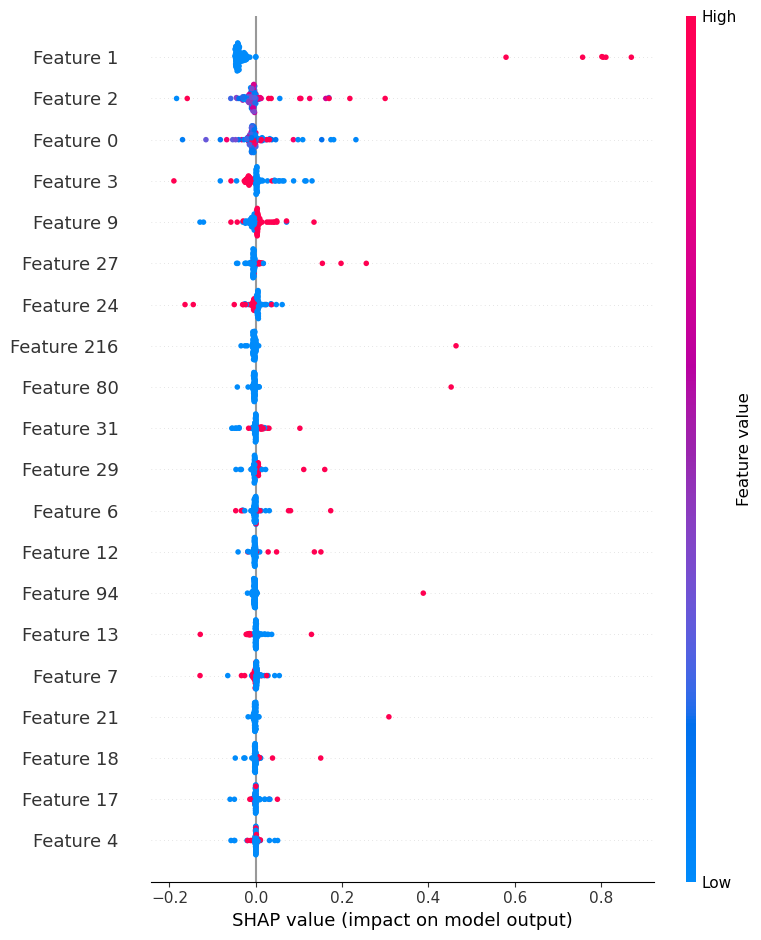

In [38]:
shap_values = rf_shap_values.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [40]:
rf_shap_values = shap.KernelExplainer(rf_clf.predict,X_train)

Using 375 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
